In [244]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

In [245]:
with open("pickled_models/model_selection.pickle", "rb") as file:
    features_df, models_df = pickle.load(file)

In [ ]:
# Showing what index of the previous dataframe corresponds to which feature set
features_df

In [ ]:
# Showing scores of every model for different feature sets
scores_df = models_df.map(lambda gs: gs.cv_results_["mean_test_score"].max())
scores_df

,LinearRegression,LassoCV,RidgeCV,ElasticNetCV,PolynomialRegression,PolynomialLasso,PolynomialRidge,PolynomialElasticNet,RandomForestRegressor,ExtraTreesRegressor,XGBRegressor,XGBRFRegressor,MLPRegressor
0,0.807458,0.807463,0.807459,0.807463,0.819406,0.819490,0.819430,0.819483,0.817286,0.818950,0.815495,0.817178,0.816678
1,0.808430,0.808282,0.808424,0.808262,0.818568,0.819351,0.818869,0.819317,0.815966,0.818737,0.814367,0.815527,0.815870
2,0.803688,0.803693,0.803654,0.803693,0.818116,0.818892,0.818203,0.818900,0.815117,0.818554,0.812496,0.814445,0.820480


<b>Preparing data for model prediction visualization</b>

In [ ]:
df = pd.read_csv("./combine_2010_2025")
data = df[["Vertical", "Ht", "Wt"]].copy()
data["Relative-mass"] = df["Wt"] / df["Ht"] ** 3
data["Relative-vertical"] = df["Vertical"] / df["Ht"]
data["40yd"] = df["40yd"]
data = data.dropna()

In [ ]:

med_vertical = data["Vertical"].median()
med_wt = data["Wt"].median()
med_ht = data["Ht"].median()
med_relative_vertical = data["Relative-vertical"].median()
extrapolation_vertical = np.arange(18, 50, 0.5)
extrapolation_wt = np.arange(120, 400, 1)



In [251]:
features_df

,Features,Scaler
0,"(Vertical, Wt)",StandardScaler()
1,"(Vertical, Wt, Relative-vertical)",StandardScaler()
2,"(Wt, Relative-mass, Relative-vertical)",StandardScaler()


<p>We will be showing how 40 yard dash predictions change depending on different manipulated parameters of our choice. For this, we create data that the models will make predictions based on. Linearly changing values are used for the manipulated parameter. The rest of the parameters either remains constant, or also changes if the parameter is dependent on the manipulated parameter<p>
<p>For example, suppose the manipulated parameter is <b>vertical jump height</b>, and the remaining parameters are <b>weight</b> and <b>relative vertical jump height</b> (that is, vertical jump height divided by height). In that case, vertical jump height might assume values between 18 and 50 (inches), weight will be the median weight from our dataset in all datapoints, while relative vertical will be based on the respective vertical jump height value, divided by median height from our dataset.<p>

<p>This allows us to see how the relationship between different parameters and our predicted parameter (the 40 yard dash time) is represented by different regression models, which can aid in selecting the right one. A good model should extrapolate in a way that is realistic and interpolate smoothly (without overfitting).

In [ ]:
# Following data will be used to visualize how 40 yard dash predictions change depending on a manipulated parameter
# Naming convention for data:
# extrapolation_data_[feature set index]_[manipulated parameter name]
extrapolation_data_0_vertical = pd.DataFrame({
    "Vertical": extrapolation_vertical,
    "Wt": [med_wt] * extrapolation_vertical.size
})
extrapolation_data_0_vertical = features_df.loc[0, "Scaler"].transform(extrapolation_data_0_vertical)



In [253]:
extrapolation_data_0_wt = pd.DataFrame({
    "Vertical": [med_vertical] * extrapolation_wt.size,
    "Wt": extrapolation_wt,
})
extrapolation_data_0_wt = features_df.loc[0, "Scaler"].transform(extrapolation_data_0_wt)

In [254]:
extrapolation_data_1_vertical = pd.DataFrame({
    "Vertical": extrapolation_vertical,
    "Wt": [med_wt] * extrapolation_vertical.size,
    "Relative-vertical": extrapolation_vertical / med_ht
})
extrapolation_data_1_vertical = features_df.loc[1, "Scaler"].transform(extrapolation_data_1_vertical)

In [255]:
extrapolation_data_1_wt = pd.DataFrame({
    "Vertical": [med_vertical] * extrapolation_wt.size,
    "Wt": extrapolation_wt,
    "Relative-vertical": [med_vertical / med_ht] * extrapolation_wt.size
})
extrapolation_data_1_wt = features_df.loc[1, "Scaler"].transform(extrapolation_data_1_wt)

In [256]:
extrapolation_data_2_vertical = pd.DataFrame({
    "Wt": [med_wt] * extrapolation_vertical.size,
    "Relative-mass": [med_wt / med_ht ** 3] * extrapolation_vertical.size,
    "Relative-vertical": extrapolation_vertical / med_ht
})
extrapolation_data_2_vertical = features_df.loc[2, "Scaler"].transform(extrapolation_data_2_vertical)

In [257]:
extrapolation_data_2_wt = pd.DataFrame({
    "Wt": extrapolation_wt,
    "Relative-mass": extrapolation_wt / med_ht ** 3,
    "Relative-vertical": [med_relative_vertical] * extrapolation_wt.size
})
extrapolation_data_2_wt = features_df.loc[2, "Scaler"].transform(extrapolation_data_2_wt)

In [258]:
extrapolation_data_df = pd.DataFrame({
    "Vertical": [extrapolation_data_0_vertical, extrapolation_data_1_vertical, extrapolation_data_2_vertical],
    "Wt": [extrapolation_data_0_wt, extrapolation_data_1_wt, extrapolation_data_2_wt]
})
extrapolation_input_variable_df = pd.DataFrame({
    "Vertical": [extrapolation_vertical],
    "Wt": [extrapolation_wt]
})

In [ ]:
def plot_extrapolation(extrapolating_by, model_key) -> None:
    models = [models_df.loc[i, model_key] for i in range(features_df.index.size)]
    for i in range(features_df.index.size):
        plt.plot(extrapolation_input_variable_df.loc[0, extrapolating_by],  # type: ignore
                 models[i].predict(extrapolation_data_df.loc[i, extrapolating_by]), label=str(features_df.loc[i, "Features"]))
        plt.title(f"Model: {model_key}, extrapolating by: {extrapolating_by}")
        plt.xlabel(extrapolating_by)
        plt.ylabel("40yd")
        plt.legend()

<b>Prediction visualization</b>
<p>We will be visualizing how 40 yard dash predictions of every model change depending on an athlete's vertical jump and weight. Parameters dependent on the manipulated parameter (either vertical jump or weight) will be manipulated accordingly. Others remain constant, their values being based on median values from the dataset.<p>

In [279]:
features_df

,Features,Scaler
0,"(Vertical, Wt)",StandardScaler()
1,"(Vertical, Wt, Relative-vertical)",StandardScaler()
2,"(Wt, Relative-mass, Relative-vertical)",StandardScaler()


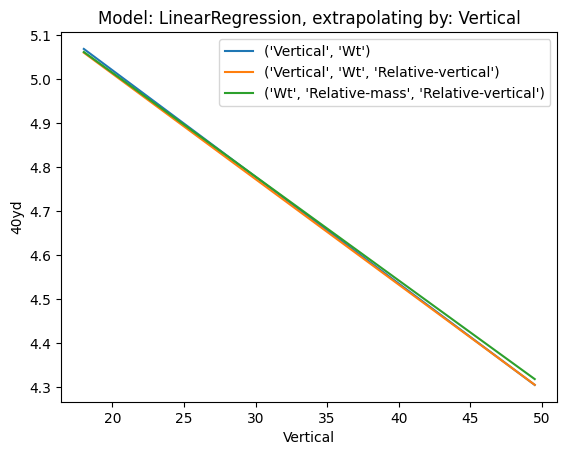

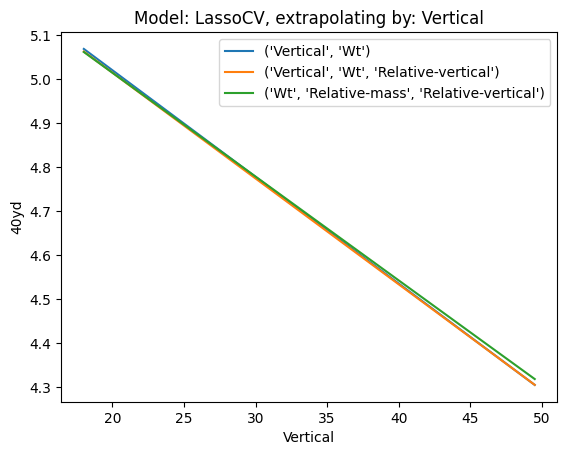

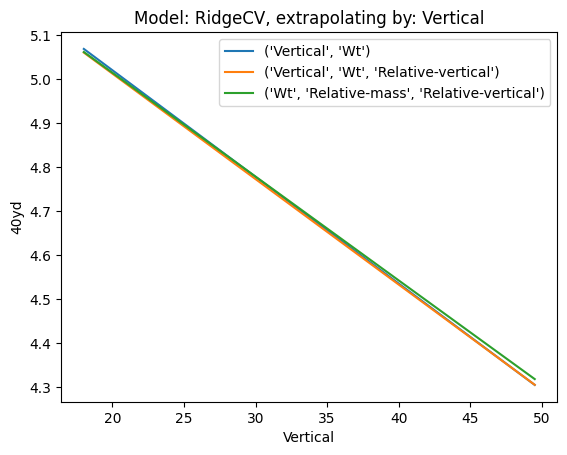

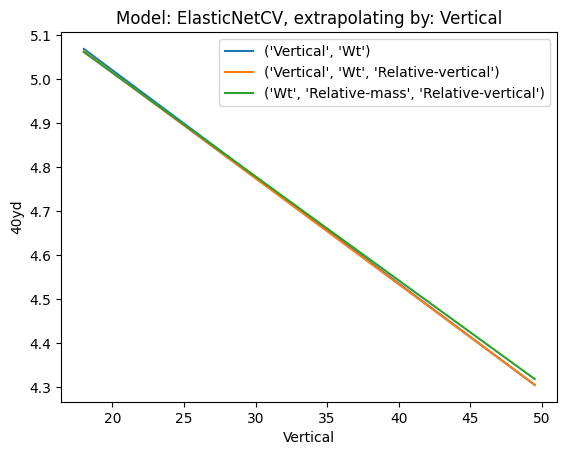

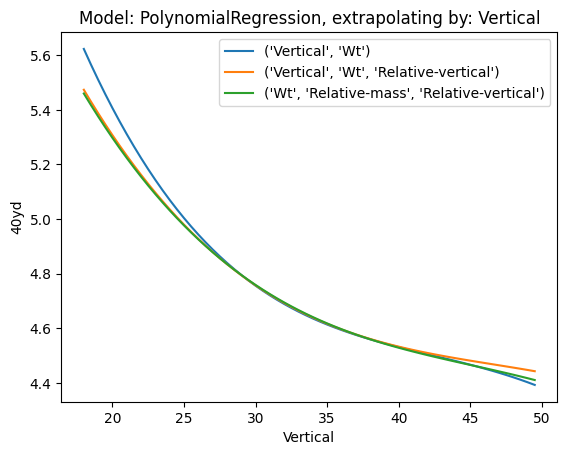

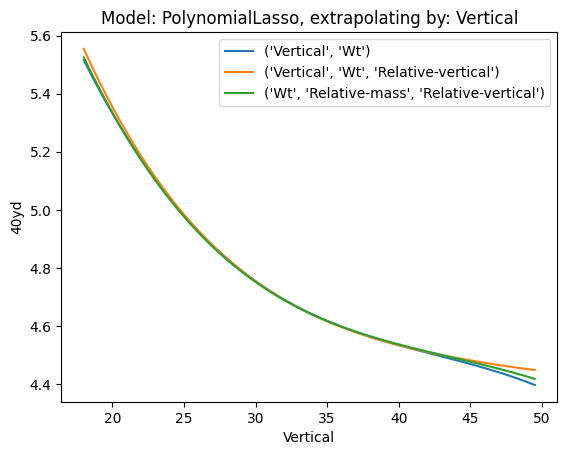

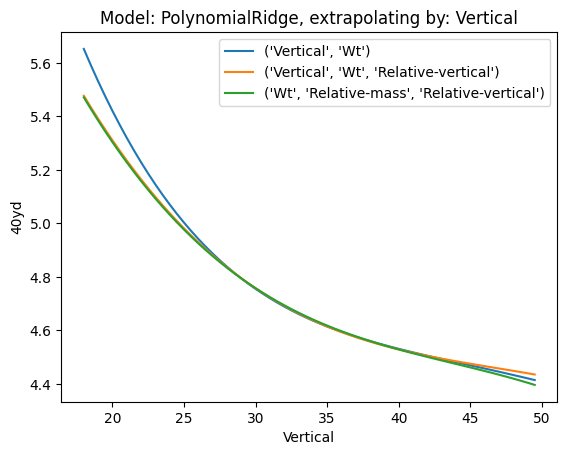

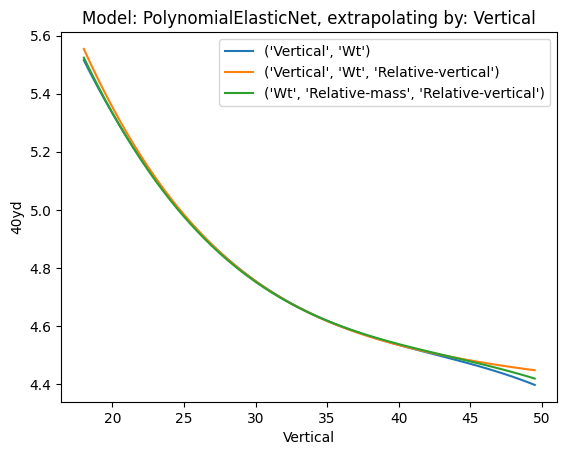

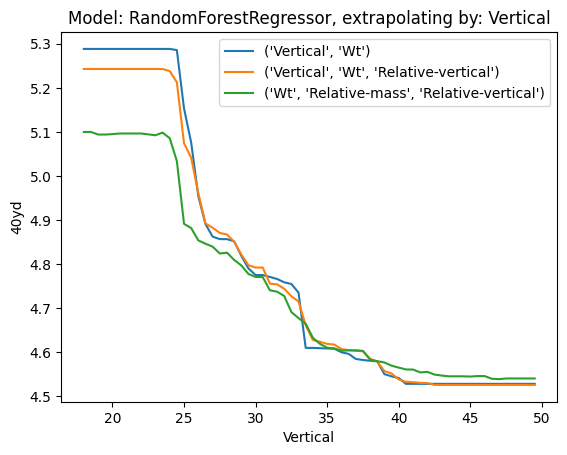

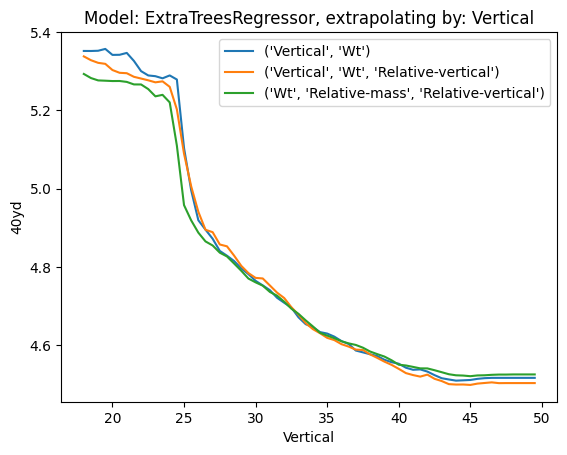

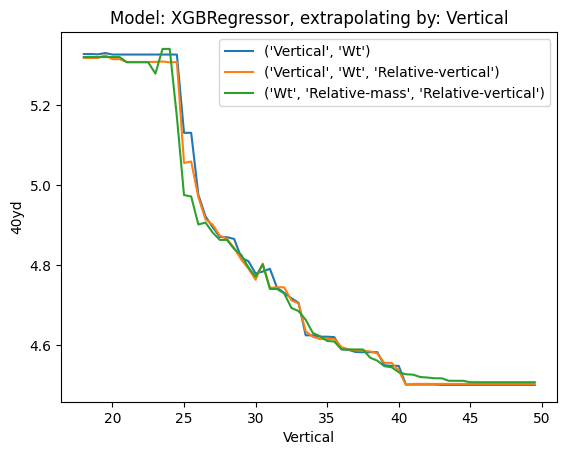

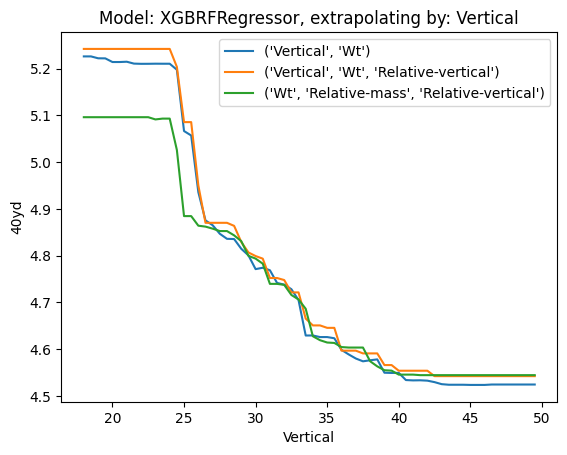

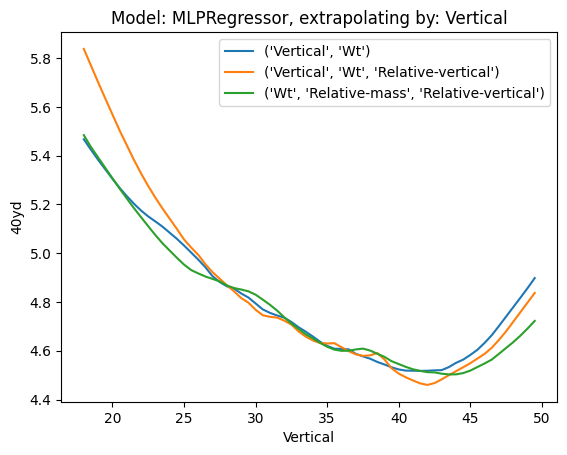

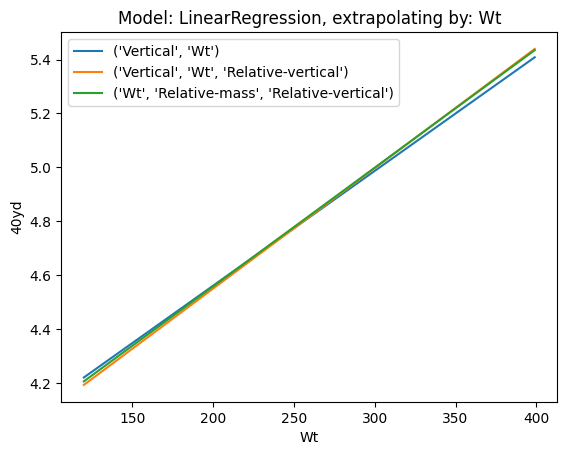

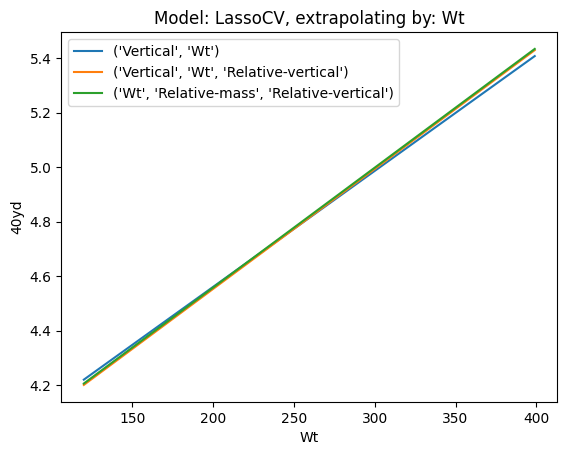

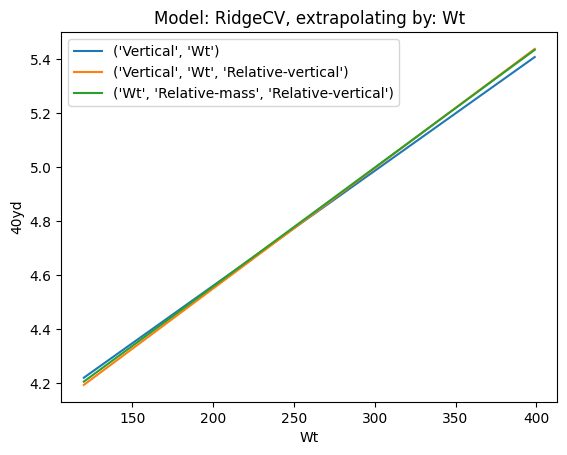

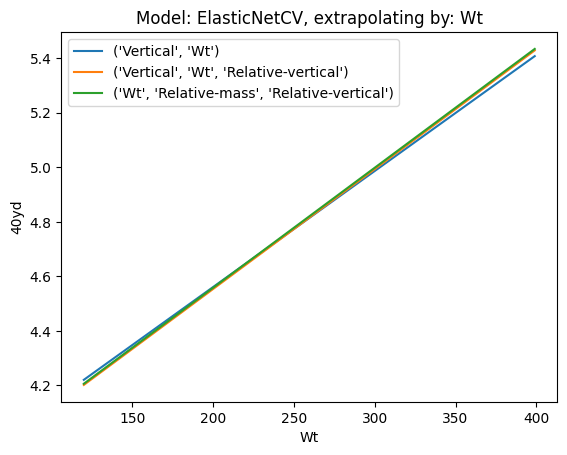

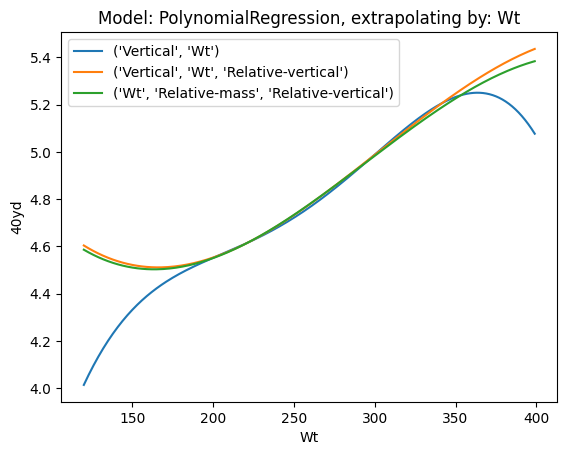

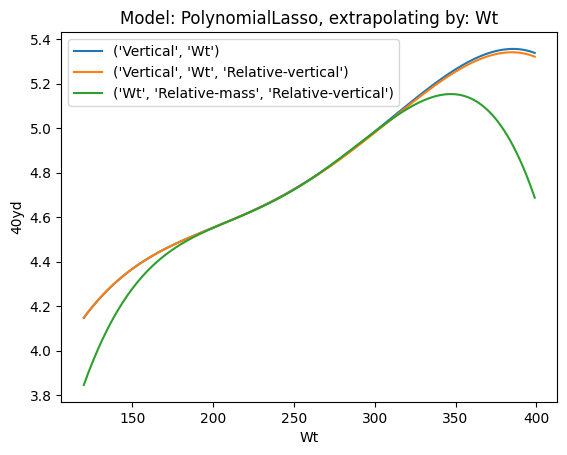

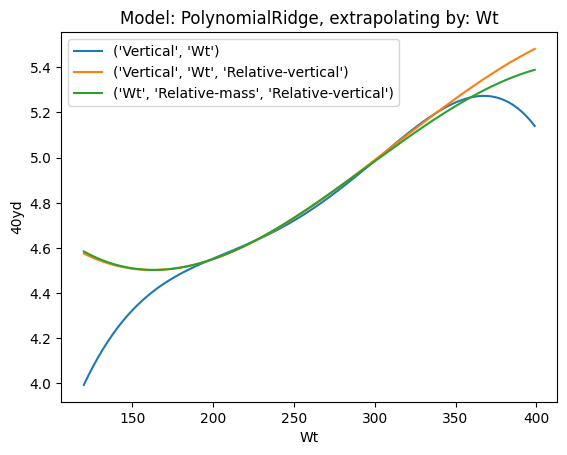

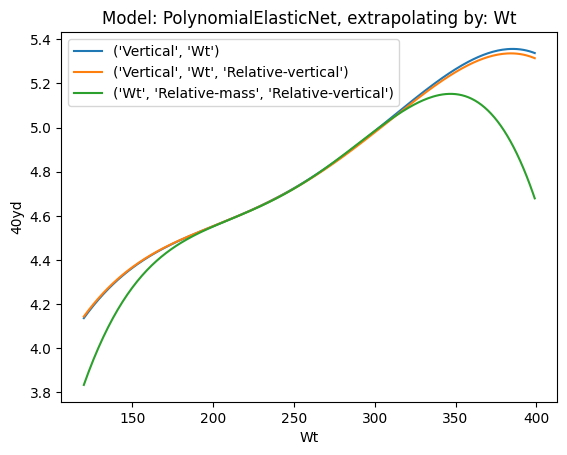

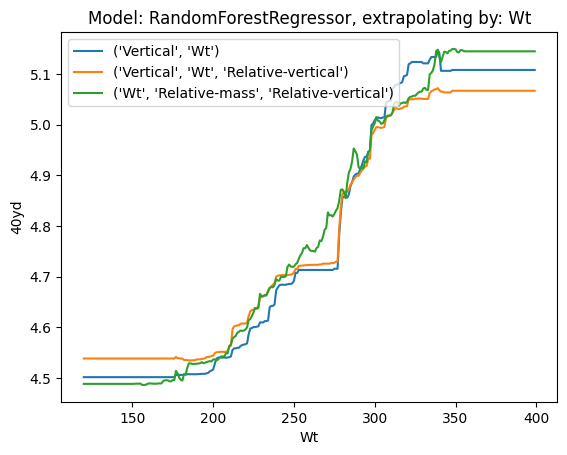

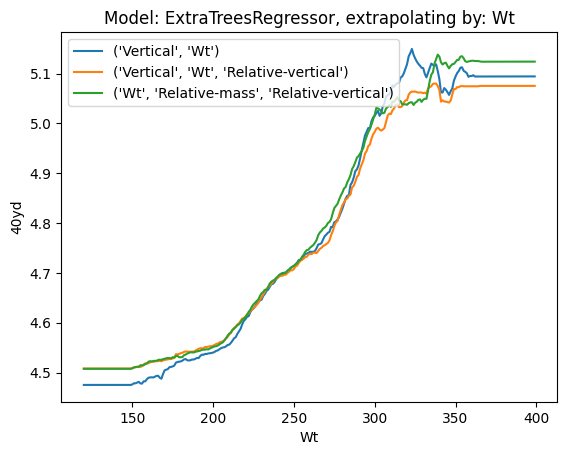

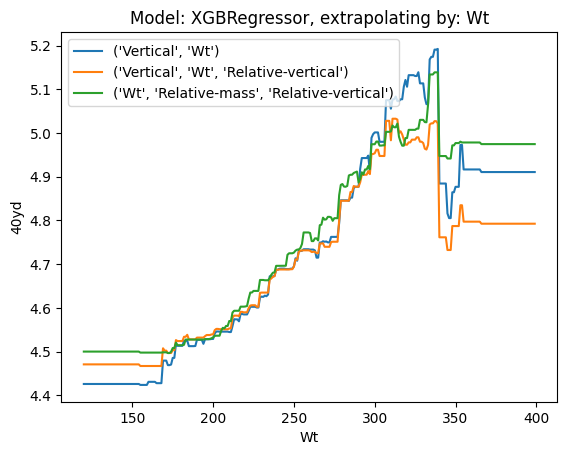

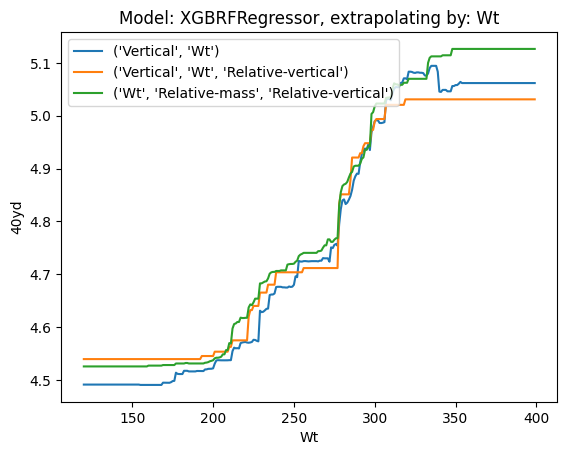

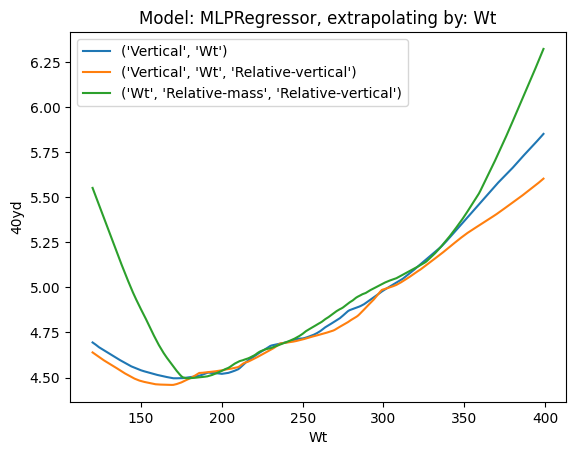

In [278]:
for extrapolating_by in extrapolation_data_df.columns:
    for model_key in models_df.columns:
        plt.figure()
        plot_extrapolation(extrapolating_by, model_key)
        plt.show()
        